In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as pl
import GPflow as gpf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%javascript

// this adds a shortcut for "run all cells" (not enabled by default) to Ctl+m, r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

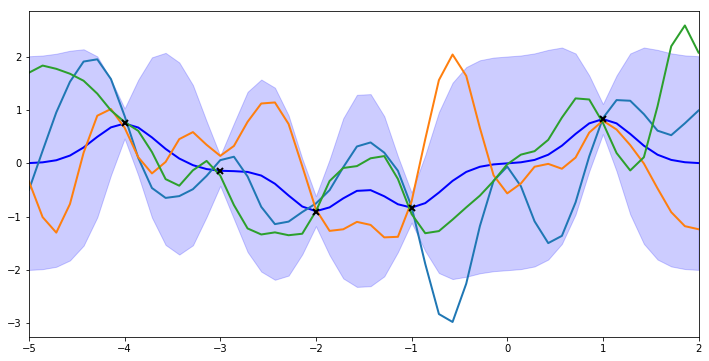

In [12]:
gpf_X = np.array([-4.0, -3.0, -2.0, -1.0, 1.0]).reshape(5,1)
gpf_Y = np.sin(gpf_X)
#gpf_X = np.random.rand(N,1)
#gpf_Y = np.sin(12*gpf_X) + 0.66*np.cos(25*gpf_X) + np.random.randn(N,1)*0.1 + 3
#print(gpf_X)
#print(gpf_Y)

k = gpf.kernels.RBF(1)
m = gpf.gpr.GPR(gpf_X, gpf_Y, kern=k)
m.likelihood.variance = 0.01
m.kern.lengthscales = .316

def plot(m):
    xx = np.linspace(-5, 2, 50)[:,None]
    mean, var = m.predict_y(xx)

    pl.figure(figsize=(12, 6))
    pl.plot(xx, mean, 'b', lw=2)
    pl.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    pl.xlim(-5, 2)
    
    #sample from the posterior fnction distribution
    post_f_samples = m.predict_f_samples(xx, 3)
    for i in range(0, 3):
        pl.plot(xx, post_f_samples[i], lw=2)
        
    pl.plot(gpf_X, gpf_Y, 'kx', mew=2)
plot(m)

## Playing with GPS

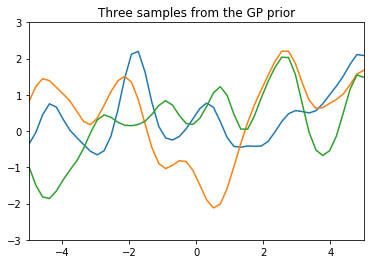

In [5]:
# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = .316
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

In [18]:
print(K_ss)

[[  1.00000000e+00   9.36223722e-01   7.68278297e-01 ...,   5.99276935e-64
    1.14470475e-66   1.91654352e-69]
 [  9.36223722e-01   1.00000000e+00   9.36223722e-01 ...,   2.74992548e-61
    5.99276935e-64   1.14470475e-66]
 [  7.68278297e-01   9.36223722e-01   1.00000000e+00 ...,   1.10604697e-58
    2.74992548e-61   5.99276935e-64]
 ..., 
 [  5.99276935e-64   2.74992548e-61   1.10604697e-58 ...,   1.00000000e+00
    9.36223722e-01   7.68278297e-01]
 [  1.14470475e-66   5.99276935e-64   2.74992548e-61 ...,   9.36223722e-01
    1.00000000e+00   9.36223722e-01]
 [  1.91654352e-69   1.14470475e-66   5.99276935e-64 ...,   7.68278297e-01
    9.36223722e-01   1.00000000e+00]]


(50,)
[ 0.957825    0.86589325  0.67317823  0.3903554   0.12948651  0.03928929
  0.13734749  0.25525549  0.22575078  0.09185091  0.04196863  0.14484135
  0.25258935  0.21120759  0.07981177  0.04648039  0.16051675  0.26209865
  0.20758463  0.07213283  0.05703505  0.246835    0.53776159  0.77913466
  0.90098921  0.9009891   0.77913429  0.53776096  0.24683444  0.05703497
  0.0721323   0.20758009  0.26208755  0.16050575  0.04647947  0.0797934
  0.21107686  0.2522929   0.14457704  0.04196043  0.09121323  0.22188432
  0.24711017  0.13077362  0.03927274  0.1044973   0.23598917  0.24859802
  0.12295905  0.03844258]
[ 0.957825    0.86589325  0.67317823  0.3903554   0.12948651  0.03928929
  0.13734749  0.25525549  0.22575078  0.09185091  0.04196863  0.14484135
  0.25258935  0.21120759  0.07981177  0.04648039  0.16051675  0.26209865
  0.20758463  0.07213283  0.05703505  0.246835    0.53776159  0.77913466
  0.90098921  0.9009891   0.77913429  0.53776096  0.24683444  0.05703497
  0.0721323   0.2075

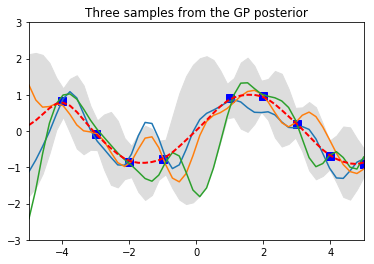

In [48]:
# Noised up training data
Xtrain = np.array([-4, -3, -2, -1, 1, 2, 3, 4, 5]).reshape(9,1)

noise_mu, noise_sigma = 0, .2
ytrain = np.sin(Xtrain)  + np.random.normal(noise_mu, noise_sigma)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)) + ((noise_sigma ** 2)*np.eye(len(Xtrain))))

L_y = np.linalg.solve(L, ytrain)
a = np.linalg.solve(L.T, L_y)

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)

means = np.dot(K_s.T, a).reshape(n,)
v = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

#print(means)
#print(mu)


# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(v**2, axis=0)
variances = K_ss - np.dot(v.T, v)

#we only want the diagonal because we want to know the variance of each variable independent of any others
print(s2.shape)
print(np.diag(variances))
print(s2)


stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
#print(f_post.shape)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()